## Hydrograph Development Notebooks



# Methodology Overview:

### Reproduce [Grand Rapids Michigan Test Cast](documentation\ProofofConceptHydrologyStudies.pdf) 



In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from scipy.integrate import trapz, cumtrapz, simps

from importlib import reload
import utils; reload(utils)
from utils import *

%matplotlib inline

In [2]:
import ny_clean_nb; reload(ny_clean_nb)
from ny_clean_nb import *
df = initialize_testcase()

**Read in USGS Gage Records**

01509000_00060_dv.tsv
01509000_00060_iv.tsv
01509000_00065_iv.tsv
01509520_00065_iv.tsv
01511500_00065_iv.tsv
04119000_00060_dv.tsv
04119000_00060_iv.tsv
04119000_00065_iv.tsv


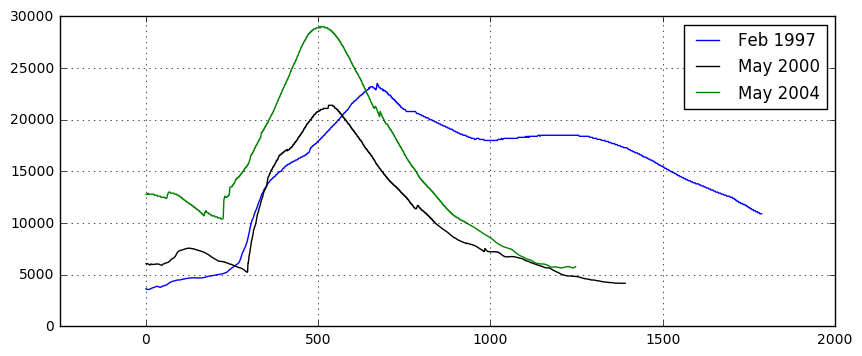

In [3]:
testcase = df[['04119000_00060_iv']].interpolate().copy()
storm1 = testcase['1997-02-17 18:00':'1997-03-10'].values
storm2 = testcase['2000-05-12':'2000-06-09'].values
storm3 = testcase['2004-05-17':'2004-06-11'].values
f, ax = plt.subplots()
ax.plot(np.arange(0, len(storm1)),storm1 ,color = 'blue', label = 'Feb 1997')
ax.plot(np.arange(0, len(storm2)),storm2 ,color = 'black',label = 'May 2000')
ax.plot(np.arange(0, len(storm3)),storm3 ,color = 'green',label = 'May 2004')
ax.grid()
ax.legend()
ax.set_xlim(-250, 2000)
f.set_size_inches(10,4)

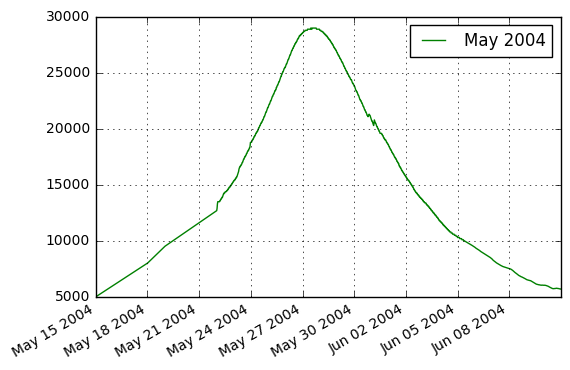

In [4]:
testcase = df[['04119000_00060_iv']].interpolate().copy()
storm3 = testcase['2004-05-15 00:00 ':'2004-06-10'].copy()
storm3['2004-05-15 00:00':'2004-05-22 00:00'] = np.nan
len(storm3['2004-05-15 00:00':'2004-05-22 00:00'])
idx =storm3.index[-337:]
storm3['2004-05-15 00:00':'2004-05-15 00:00'] = 5000
storm3['2004-05-16 00:00':'2004-05-16 00:00'] = 6000
storm3['2004-05-17 00:00':'2004-05-17 00:00'] = 7000
storm3['2004-05-18 00:00':'2004-05-18 00:00'] = 8000
storm3['2004-05-19 00:00':'2004-05-19 00:00'] = 9500

smooth_storm = storm3.interpolate(how = 'spline', order=3) 

f, ax = plt.subplots()
ax.plot(smooth_storm,color = 'green',label = 'May 2004')
ax.grid()
ax.legend()

f.set_size_inches(6,4)
f.autofmt_xdate()

In [5]:
peak = float(storm3.max())
pct_1 = 50000
pct_02 = 65200

stretch_1pct = pct_1/peak 
stretch_02pct = pct_02/peak 

smooth_storm_resample = smooth_storm.resample('30T').mean()

smooth_storm_1pct = smooth_storm_resample*stretch_1pct
smooth_storm_02pct = smooth_storm_resample*stretch_02pct

print('Factors: \n','\t1 Percent\t{}'.format(stretch_1pct), '\n\t0.2 Percent\t{}'.format(stretch_02pct))

Factors: 
 	1 Percent	1.7241379310344827 
	0.2 Percent	2.2482758620689656


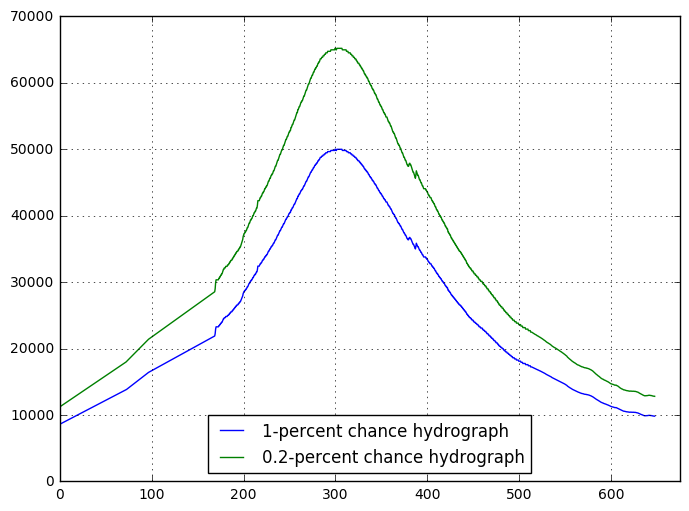

In [6]:
storm01 = smooth_storm_1pct.values
storm02 = smooth_storm_02pct.values
idx = np.arange(0, len(storm01))
f, ax = plt.subplots()
ax.plot(idx,storm01 ,color = 'blue', label = '1-percent chance hydrograph')
ax.plot(idx,storm02 ,color = 'green', label = '0.2-percent chance hydrograph')

ax.grid()
ax.legend(loc=0)
my_xticks = np.multiply(idx,100)
ax.set_xticklabels(my_xticks)
ax.set_xlim(0,1350)
f.set_size_inches(8,6)

In [7]:
#--Calculate Volume to Verify Procedure
printbold('Volume Check')

may_volume = IntegrateHydrograph(smooth_storm, 4900.)
print('May Event\t',may_volume, 'inches' )
pct_1_volume = IntegrateHydrograph(smooth_storm_1pct, 4900.)
print('1 Percent\t', pct_1_volume, 'inches')
pct_02_volume = IntegrateHydrograph(smooth_storm_02pct, 4900.)
print('0.2 Percent\t',pct_02_volume, 'inches')

**Volume Check**

May Event	 2.95 inches
1 Percent	 5.09 inches
0.2 Percent	 6.64 inches


# Concept Checker Complete, Procedure Verified
### Next Steps: Compare stretching via factor to peak only interpolation


In [9]:
# Method #1
pct_1_peak, inst_peak  = Stretched_Daily_100yr(df, plot = False)
peak =  14209.0
pct_1 = 20960.0
stretch_1pct = pct_1/peak 
smooth_storm_resample = inst_peak.resample('30T').mean()
smooth_storm_1pct = smooth_storm_resample*stretch_1pct
print('Factor: \n','\t1 Percent\t{}'.format(stretch_1pct))



Factor: 
 	1 Percent	1.4751214019283552


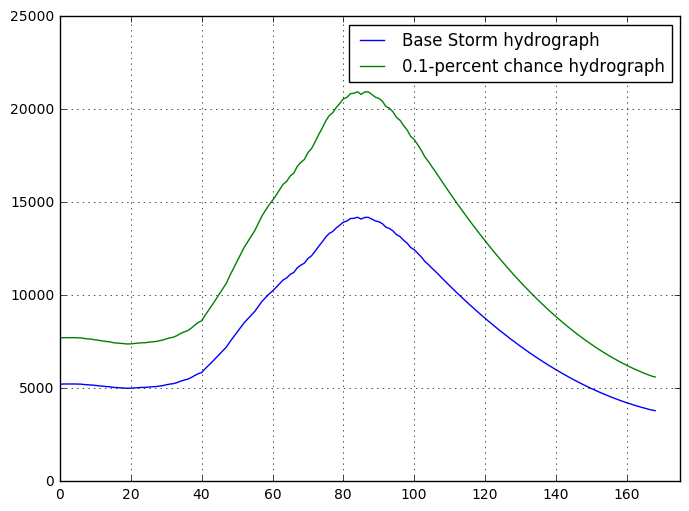

In [10]:
# APPLY TO NY DATA
storm01 = smooth_storm_resample.values
storm02 = smooth_storm_1pct.values
idx = np.arange(0, len(storm01))
f, ax = plt.subplots()
ax.plot(idx,storm01 ,color = 'blue', label = 'Base Storm hydrograph')
ax.plot(idx,storm02 ,color = 'green', label = '0.1-percent chance hydrograph')

ax.grid()
ax.legend(loc=0)
ax.set_xlim(0,175)
f.set_size_inches(8,6)

**Volume Check**

Base Hydrograph	 5.09 inches
Stretch Method	 2.95 inches
Factor Method 6.64 inches


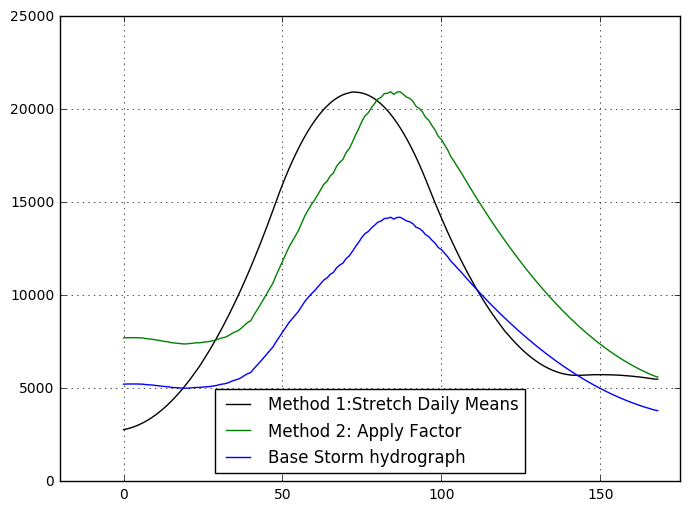

In [11]:
pct_1_peak, inst_peak  = Stretched_Daily_100yr(df, plot = False)
storm0 = pd.DataFrame(pct_1_peak).resample('30T').mean().values
storm01 = smooth_storm_resample.values
storm02 = smooth_storm_1pct.values
idx = np.arange(0, len(storm01))
f, ax = plt.subplots()

ax.plot(idx,storm0 ,color = 'black', label = 'Method 1:Stretch Daily Means')
ax.plot(idx,storm02 ,color = 'green', label = 'Method 2: Apply Factor')
ax.plot(idx,storm01 ,color = 'blue', label = 'Base Storm hydrograph')

ax.grid()
ax.legend(loc=0)
ax.set_xlim(-20,175)
f.set_size_inches(8,6)

#--Calculate Volume to Verify Procedure
printbold('Volume Check')
raw  = IntegrateHydrograph(smooth_storm_resample, 490.)
print('Base Hydrograph\t', pct_1_volume, 'inches')

stretched = IntegrateHydrograph(pct_1_peak, 490.)
print('Stretch Method\t',may_volume, 'inches' )

factored = IntegrateHydrograph(smooth_storm_1pct, 490.)
print('Factor Method',pct_02_volume, 'inches')